In [1]:
import numpy as np
import random
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchmetrics.classification import AUROC, Accuracy
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve,\
                            average_precision_score, accuracy_score, f1_score,\
                            precision_score, recall_score, classification_report
import os
from sklearn.model_selection import train_test_split
import shutil
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
from torchvision.models.efficientnet import efficientnet_b0 as Model
from torchvision.models.efficientnet import EfficientNet_B0_Weights as ModelW
from torchvision.models.efficientnet import EfficientNet

In [3]:
import sys
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../"))

In [4]:
import explainer.rule_pattern_miner as rlm
import explainer.explainer_utils as eutils
from explainer.integrad import integrad
from explainer.itemsets_miner import transform_intgrad_to_itemsets,gen_freq_feature_set
import explainer.integrad as integrad

In [6]:
OPTIM_PARAMS = {"lr":1e-4}
OPTIM = torch.optim.AdamW
CRITERIUM = torch.nn.CrossEntropyLoss
BATCH_SIZE = 16
IMAGE_SIZE = 256
N_EPOCHS = 50
PATIENCE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2 if DEVICE=='cuda' else 4 # fixed by kaggle notebook


In [5]:
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [7]:
class ENet(torch.nn.Module):
    
    def __init__(self,model):
        super().__init__()
        self.net = model
        self.features = torch.nn.Sequential(model.features,model.avgpool)
        self.avgpool = model.avgpool
        self.classifier = model.classifier
    
    def latent_representation(self,x):
        ### from features to output ###
#         x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def forward(self,x):
        return self.net.forwad(x)
    
        

In [8]:
class ENetUpper(ENet):
    
    
    def latent_representation(self,x):
        ### from input to features ###
        x = self.features(x)
        return x


In [9]:
data_dir = '../../data/BrainTumors/raw'
output_dir = '../../data/BrainTumors/processed'

In [11]:
### for first time process the raw data

if not os.path.exists(output_dir):

    train_percent = 0.7
    val_percent = 0.1
    test_percent = 0.2

    for root, dirs, files in os.walk(data_dir):
        print(root, dirs,files, len(files))
        if len(files) > 0:
            train_files, temp_files = train_test_split(files, test_size=(1 - train_percent), random_state=SEED)
            val_files, test_files = train_test_split(temp_files, test_size=(test_percent / (test_percent + val_percent)), random_state=SEED)
            for split_name,files in zip(["train","val","test"],[train_files,val_files,test_files]):
                new_output_dir = os.path.join(output_dir, split_name, os.path.relpath(root, data_dir))
                os.makedirs(new_output_dir, exist_ok=True)
                #print(new_output_dir)
                for file in files:
                    src = os.path.join(root, file)
                    dst = os.path.join(new_output_dir, file)
                    shutil.move(src, dst)

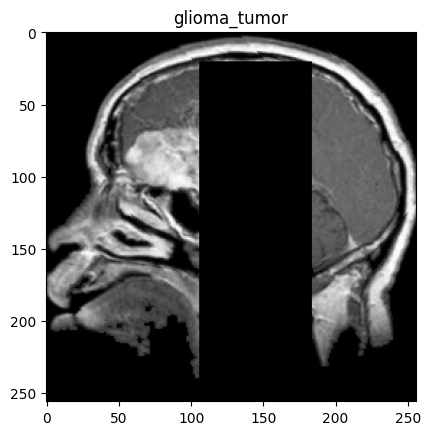

In [12]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(5,translate=[0,.1],scale=[.9,1.1]),
                                      transforms.ToTensor(),
                                      transforms.RandomErasing(),
                                     ])

transform_val = transforms.Compose([transforms.ToTensor(),])

train = ImageFolder(os.path.join(output_dir,"train"),
                    transform=transform_train,
                   )

val = ImageFolder(os.path.join(output_dir,"val"),
                    transform=transform_val,
                   )

test = ImageFolder(os.path.join(output_dir,"test"),
                    transform=transform_val,
                   )

class_names = train.classes

plt.imshow(train[0][0].transpose(0,2).transpose(1,0))
plt.title(train.classes[train[0][1]])
plt.show()

In [13]:
# loaders :
train_loader = DataLoader(train,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True,drop_last=True)
val_loader = DataLoader(val,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)
test_loader = DataLoader(test,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)

In [14]:
model = Model(weights=ModelW.IMAGENET1K_V1)

In [15]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [16]:
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features,out_features=4)

In [17]:
### load the saved model if not the first time training it

model_path = './results/BrainTumors/efficient_net'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()
    
else:
    model.to(DEVICE)

    optimizer = OPTIM(model.parameters(),**OPTIM_PARAMS)
    criterium = CRITERIUM()

    best_model = deepcopy(model)
    best_acc = 0
    patience = 0

    for epoch in range(N_EPOCHS):
        train_loss = 0
        train_total = 0
        model.train()
        for x,y in tqdm(train_loader):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            output = model(x)
            loss = criterium(output,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            train_total += x.size(0)
        train_loss /= train_total

        val_loss = 0
        val_total = 0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(DEVICE)
                y = y.to(DEVICE)
                output = model(x)
                loss = criterium(output,y)
                val_loss += loss.item() * x.size(0)
                val_total += x.size(0)
                val_acc += torch.sum(torch.argmax(output,dim=-1)==y).item()
        val_loss /= val_total
        val_acc /= val_total


        # save
        if val_acc > best_acc :
            best_acc = val_acc
            best_model = deepcopy(model)
            patience = 0
        else :
            patience += 1

        print("Epoch {} : train loss {:.4f} | val loss {:.4f} | val Acc {:.3f}".format(epoch,
                                                                                       train_loss,
                                                                                       val_loss,
                                                                                       val_acc))

        # earlystopping
        if patience >= PATIENCE :
            break
    torch.save(best_model.state_dict(), model_path)
    model = best_model
    model.eval()

In [18]:
y_true, y_pred = [], []

with torch.no_grad():
    for x,y in tqdm(test_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        output = model(x).softmax(dim=-1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(output.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [01:23<00:00,  2.14s/it]


In [19]:
y_pred_labels = y_pred.argmax(axis=1)
accuracy = accuracy_score(y_true, y_pred_labels)
report = classification_report(y_true, y_pred_labels, target_names=class_names,zero_division=0)
print(report)
print(f'Accuracy: {accuracy:.2f}')

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.91      0.93       181
meningioma_tumor       0.90      0.96      0.93       183
          normal       0.97      0.98      0.97        88
 pituitary_tumor       0.99      0.96      0.98       170

        accuracy                           0.95       622
       macro avg       0.95      0.95      0.95       622
    weighted avg       0.95      0.95      0.95       622

Accuracy: 0.95


In [20]:
train_val = ImageFolder(os.path.join(output_dir,"train"),
                    transform=transform_val,
                   )
train_val_loader = DataLoader(train_val,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True,drop_last=True)

In [21]:
emodel = ENet(model)
torch.manual_seed(SEED)


correct = 0
total = 0
X_train, X_train_raw = [],[]
y_train, pred_y_train = [],[]
train_reps = []
with torch.no_grad():
    for data in train_val_loader:
        inputs, labels = data
        
        X_train_raw.append(inputs)
        X_train.append(emodel.features(inputs).detach())
        y_train.append(labels)        
        
        outputs = model(inputs).detach()
        train_reps.append(outputs) 
        predicted = torch.argmax(outputs,dim=1)
        pred_y_train.append(predicted)        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
X_train = torch.vstack(X_train)
X_train_raw = torch.vstack(X_train_raw)
train_reps = torch.vstack(train_reps)

y_train = torch.concat(y_train).numpy()
pred_y_train = torch.concat(pred_y_train).numpy()

print(f'Accuracy on the training set: {100 * correct / total:.2f}%')

Accuracy on the training set: 99.58%


In [22]:
((pred_y_train==0)&(y_train==0)).sum()/(y_train==0).sum()

0.9952305246422893

In [23]:
baselines = eutils.gen_intgrad_baselines(X_train,y_train,train_reps)
subset = eutils.gen_balanced_subset(X_train,y_train,size_per_class=300)
int_g, z_shift = eutils.calc_baselines_intg(test_examples=subset,model=emodel,baselines=baselines,C=4)

In [24]:
y_int_g = []
C=4
n_c = int(len(int_g)/C)
int_g = int_g.squeeze()
for c in range(C):
    tmp = torch.abs(int_g[c*n_c:(c+1)*n_c,:]/z_shift[c*n_c:(c+1)*n_c,c].reshape(-1,1))
    tmp[torch.isnan(tmp)] = 0.
    
    y_int_g.append(tmp)

In [25]:
train.class_to_idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}

In [255]:
### specify the target class for generating rules
c = 2

min_support = 300   
num_grids = 20
max_depth = 2

In [256]:
### compute impact score matrix

int_g, z_shift = eutils.calc_baselines_intg(test_examples=subset,model=emodel,baselines=baselines,C=4,target_dim=c)
y_int_g = torch.abs(int_g.squeeze()/z_shift[:,c].reshape(-1,1))

### search int_g score threshold
thds = np.linspace(0.0001,0.1,1000)
f_n = []
for thd in thds:
    mask = torch.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(dim=0)>=len(y_int_g)*0.99).sum()))
    print(f_n[-1])
    if f_n[-1][1]<=1:
        break
thd = f_n[-1][0]
thd

(0.0001, tensor(123))
(0.0002, tensor(57))
(0.00030000000000000003, tensor(24))
(0.0004, tensor(12))
(0.0005, tensor(2))
(0.0006000000000000001, tensor(0))


0.0006000000000000001

In [257]:
### seatch frequent features

itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=thd,K=1)
fids = gen_freq_feature_set(itemsets_y[0],min_support=100,max_len=200)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

feature set [1087  347  886 1138 1200  115  391  393  489   75  914  292  654  152
  145 1110  457 1226 1209 1060  495  569  659  639  603 1230] 26


In [258]:
(y_train==c).sum(),(pred_y_train==c).sum()

(306, 306)

In [259]:

X_train = X_train.squeeze()



y_rule_candidates = rlm.gen_rule_list_for_one_target(X_train.numpy(),fids,pred_y_train==c,y=y_train,c=c,sort_by="fitness",
                                                            min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=3,
                                                            local_x=None,feature_types=None,search="greedy",
                                                            verbose=False)


y_rule_candidates

build_rule_tree
init rule tree
check potential rule 489 5.8379578246392905 0.5877730752292432 2.871699571609497 318
add rule [] 489 [5.8379578246392905, 489]
check potential rule 457 1.06 -0.1771567314863205 0.266360837378 300
add rule [489] 457 [1.06, 457]
check potential rule 1110 1.0564784053156144 -0.20763282477855682 0.18724240990061508 301
add rule [489] 1110 [1.0564784053156144, 1110]
check potential rule 1087 1.0529801324503312 -0.2353108674287796 0.2209029738840304 302
add rule [489] 1087 [1.0529801324503312, 1087]
check potential rule 1200 5.752414398595259 0.7767114411843451 2.8997178077697754 335
add rule [] 1200 [5.752414398595259, 1200]
check potential rule 1209 1.1166666666666667 -0.04919220428717763 3.186802864074707 300
add rule [1200] 1209 [1.1166666666666667, 1209]
check potential rule 914 1.1129568106312293 -0.1699494570493698 0.20175301401238693 301
add rule [1200] 914 [1.1129568106312293, 914]
check potential rule 569 1.1088800457571222 -0.06236279951898674 2.4626

[{'rules': [(1200, '>=', 0.7767114411843451),
   (1209, '>=', -0.04919220428717763)],
  'cond_prob_target': 0.91,
  'support': 300,
  'fitness': 0.8039215686274511,
  'cond_prob_y': 0.9066666666666666,
  'ratio_y': 0.8888888888888888},
 {'rules': [(1200, '>=', 0.7767114411843451),
   (914, '>=', -0.1699494570493698),
   (914, '<=', 0.20175301401238693)],
  'cond_prob_target': 0.9069767441860465,
  'support': 301,
  'fitness': 0.8006535947712418,
  'cond_prob_y': 0.9036544850498339,
  'ratio_y': 0.8888888888888888},
 {'rules': [(1200, '>=', 0.7767114411843451),
   (569, '>=', -0.06236279951898674)],
  'cond_prob_target': 0.9036544850498339,
  'support': 301,
  'fitness': 0.7941176470588236,
  'cond_prob_y': 0.9003322259136213,
  'ratio_y': 0.8856209150326797},
 {'rules': [(115, '>=', 0.5835278865538146),
   (639, '>=', -0.16098684072494507),
   (639, '<=', 0.13776235203993947)],
  'cond_prob_target': 0.9,
  'support': 300,
  'fitness': 0.7843137254901961,
  'cond_prob_y': 0.9,
  'ratio_

In [260]:
y_rule_candidates

[{'rules': [(1200, '>=', 0.7767114411843451),
   (1209, '>=', -0.04919220428717763)],
  'cond_prob_target': 0.91,
  'support': 300,
  'fitness': 0.8039215686274511,
  'cond_prob_y': 0.9066666666666666,
  'ratio_y': 0.8888888888888888},
 {'rules': [(1200, '>=', 0.7767114411843451),
   (914, '>=', -0.1699494570493698),
   (914, '<=', 0.20175301401238693)],
  'cond_prob_target': 0.9069767441860465,
  'support': 301,
  'fitness': 0.8006535947712418,
  'cond_prob_y': 0.9036544850498339,
  'ratio_y': 0.8888888888888888},
 {'rules': [(1200, '>=', 0.7767114411843451),
   (569, '>=', -0.06236279951898674)],
  'cond_prob_target': 0.9036544850498339,
  'support': 301,
  'fitness': 0.7941176470588236,
  'cond_prob_y': 0.9003322259136213,
  'ratio_y': 0.8856209150326797},
 {'rules': [(115, '>=', 0.5835278865538146),
   (639, '>=', -0.16098684072494507),
   (639, '<=', 0.13776235203993947)],
  'cond_prob_target': 0.9,
  'support': 300,
  'fitness': 0.7843137254901961,
  'cond_prob_y': 0.9,
  'ratio_

In [295]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree,export_text,export_graphviz
import explainer.DT_rules as dtr


feature_names = ["z"+str(i) for i in range(X_train.shape[1])]

treemodel = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_support,random_state=SEED)
treemodel.fit(X_train,pred_y_train==c)

rule_list, rule_value_list, rule_metric_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_train.numpy(),y_train,pred_y_train==c,np.arange(X_train.shape[-1]),feature_names,c=c)
print(export_text(treemodel))

|--- feature_115 <= 0.69
|   |--- feature_510 <= -0.02
|   |   |--- class: False
|   |--- feature_510 >  -0.02
|   |   |--- class: False
|--- feature_115 >  0.69
|   |--- class: True



In [296]:
## display rules extracted by DT classifier
dtr.display_rules_from_DT(rule_list,rule_metric_list,feature_names)

#################
[(115, '<=', 0.689), (510, '<=', -0.021)]
cond_prob_target 0.136 cond_prob_y 0.13 support 301 fitness -0.716
z115 <= 0.689
z510 <= -0.021
#################
[(115, '<=', 0.689), (510, '>', -0.021)]
cond_prob_target 0.0 cond_prob_y 0.001 support 1557 fitness -5.088
z115 <= 0.689
z510 > -0.021
#################
[(115, '>', 0.689)]
cond_prob_target 0.877 cond_prob_y 0.877 support 302 fitness 0.745
z115 > 0.689


In [263]:
### Following code only for visualization ###

prefix = "./results/BrainTumors/
if not os.path.exists(prefix):
    os.mkdir(prefix)

r1 = y_rule_candidates[0]["rules"]
r=r1[0]

seen = set()
keys = [r[0] for r in r1 if not (r[0] in seen or seen.add(r[0]))]

rdict = {}
for key in keys:
    for r in r1:
        if r[0] == key:
            rdict[key] = rdict.get(key,[])
            rdict[key].append(r)



{1200: [(1200, '>=', 0.7767114411843451)],
 1209: [(1209, '>=', -0.04919220428717763)]}

(1200, '>=', 0.7767114411843451)
(1209, '>=', -0.04919220428717763)
incorrect, true 0 predict 0


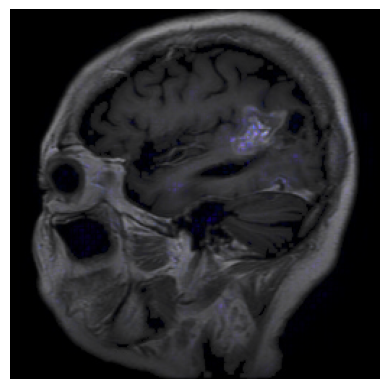

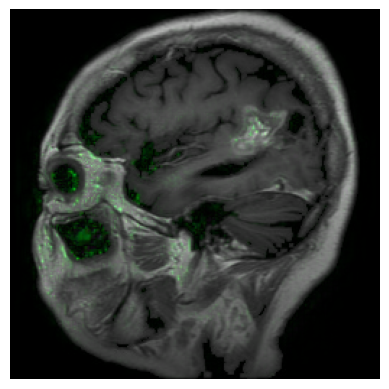

In [290]:
emodel_upper = ENetUpper(model)
raw_baselines = eutils.gen_intgrad_baselines(X_train_raw,y_train)


file_type = ".svg"
cids = np.arange(C)
k =  c
tn = ["_correct_","_incorrect_"]
ids = torch.ones(len(X_train)).bool()
for kk,fid in enumerate(keys):
    rs = rdict[fid]    
    for r in rs:
        print(r)
        ids = rlm.op_map[r[1]](X_train[:,r[0]],r[2]) & ids
imgs = X_train_raw[ids] ## images satisfy the top rule set
lbs = y_train[ids]
plbs = pred_y_train[ids]
    
correct = imgs[(lbs==plbs)&(plbs==c)][0]
incorrect = imgs[(plbs!=c)][0]
print("incorrect, true",lbs[(plbs!=c)][0],"predict",plbs[(plbs!=c)][0])

for t, test_sample in enumerate([correct,incorrect]):
    if t==0:
        continue
    for kk,fid in enumerate(keys):
        test_sample = test_sample.unsqueeze(0)
        s_int_g,s_latent_shift = [],[]
        for ci in cids[cids!=k]:
            s_int_g_i,s_latent_shift_i = integrad.integrad(test_examples=test_sample,model=emodel_upper, 
                                                      input_baseline=raw_baselines[ci],n_bins=100,target_dim=fid)
            s_int_g.append(s_int_g_i)
            s_latent_shift.append(s_latent_shift_i)

        s_int_g = torch.vstack(s_int_g)
        s_latent_shift = torch.vstack(s_latent_shift)

        s_int_g_avg = torch.abs(s_int_g/s_latent_shift[:,fid,:,:]).mean(axis=0)
        s_int_g_avg = s_int_g_avg/s_int_g_avg.max()
        
        test_sample = test_sample.squeeze()
        tmp = s_int_g_avg+test_sample
        tmp = (tmp - tmp.min())/(tmp.max()-tmp.min())
        plt.axis('off')
        plt.imshow(tmp.transpose(0,2).transpose(1,0))
        
        plt.savefig(os.path.join(prefix,"single_rule_gsample_c"+str(c)+tn[t]+"r"+str(kk)+"_img"+file_type),bbox_inches="tight")
        plt.show()
        plt.close()
    
